In [1]:
import pathlib
import numpy as np
import plotly.express as px
import pandas as pd

In [2]:
meta_df = None

In [3]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates["econ"] = go.layout.Template(
layout = {
    # Fonts
    # Note - 'family' must be a single string, NOT a list or dict!
    'title':
        {'font': {'family': 'Roboto Condensed, bold', 
                  'size':24,
                  'color': '#333'}
        },
    'font': {'family': 'Roboto Condensed', 
                  'size':18,
                  'color': '#333'},
    # Colorways
    #'colorway': ['#ec7424', '#a4abab'],
    # Keep adding others as needed below
    'margin': {'l':20, 'r':20, 't':140, 'b':20},
    'paper_bgcolor':"#fff5e6",
    'width':1600,
    'height': 900,
    },
)
pio.templates["econ"].layout.autosize = False

px.defaults.template = "ggplot2+econ"

,index,tot_fd_unmet,aff_fd_unmet,rebuild_durations,shortage_b,shortage_date_start,shortage_date_end,shortage_date_max,shortage_ind_max,shortage_ind_mean,...,prod_lost_unaff,region,q_dmg,pib,psi,inv_tau,flood_int,n_timesteps,has_crashed,prod_lost_aff
9,9,6.477381e+03,3147.790854,532,True,239,384,313,0.122396,0.098294,...,1.571373e+01,AT,NaN,0.014480,0.85,6,99%,730,False,4202.096047
10,10,1.516676e+04,10697.167467,636,True,216,514,431,0.307292,0.168528,...,1.327117e+02,AT,NaN,0.020977,0.85,6,max,730,False,23146.660248
20,20,1.140729e+05,86864.407660,725,True,140,441,290,3.731771,1.062491,...,5.657760e+04,AU,NaN,0.006298,0.85,6,99%,730,False,194849.144794
21,21,3.436085e+06,212884.651958,725,True,66,605,405,10.023438,3.879682,...,7.254940e+06,AU,NaN,0.014994,0.85,6,max,730,False,480283.467556
31,31,9.194686e+03,5524.006257,588,True,186,362,290,0.091146,0.067753,...,6.035768e+02,BE,NaN,0.009419,0.85,6,99%,730,False,13105.191119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,393,2.027223e+03,878.618609,514,True,201,407,332,0.205729,0.106493,...,1.801969e+03,SK,NaN,0.016526,0.85,6,90%,730,False,44.124397
394,394,2.786158e+03,1028.236497,562,True,184,443,350,0.221354,0.122949,...,3.191702e+03,SK,NaN,0.020021,0.85,6,99%,730,False,103.676348
395,395,2.877380e+03,1045.726980,567,True,183,447,380,0.223958,0.124457,...,3.361178e+03,SK,NaN,0.020432,0.85,6,max,730,False,111.344266
416,416,2.214503e+05,22741.904491,248,True,150,457,287,0.260417,0.122065,...,4.890100e+05,US,NaN,0.000672,0.85,6,99%,730,False,3276.850117


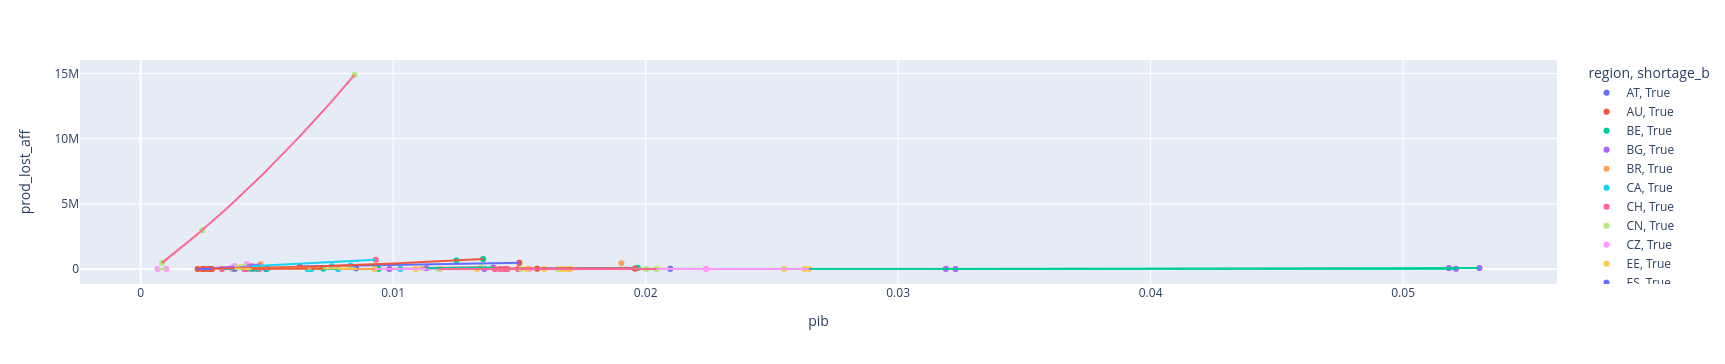

In [91]:
import pandas as pd
import numpy as np
import pathlib
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


def format_coefs(coefs):
    equation_list = [f"{coef}x^{i}" for i, coef in enumerate(coefs)]
    equation = "$" +  " + ".join(equation_list) + "$"

    replace_map = {"x^0": "", "x^1": "x", '+ -': '- '}
    for old, new in replace_map.items():
        equation = equation.replace(old, new)

    return equation

def model(df,fig, to_fit):
    y = df[[to_fit]].values
    X = df[['pib']].values
    x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    for degree in [2]:
        poly = PolynomialFeatures(degree)
        poly.fit(X)
        X_poly = poly.transform(X)
        x_range_poly = poly.transform(x_range)
        model = LinearRegression(fit_intercept=False)
        model.fit(X_poly, df[to_fit])
        y_poly = model.predict(x_range_poly)
        equation = format_coefs(model.coef_.round(2))
        fig.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=df.region.iloc[0]))
    return fig
    #model = model.fit(X, y)
    #x_range = np.linspace(X.min(), X.max(), 50)
    #y_range = model.predict(x_range.reshape(-1, 1))
   # print('x_range:',x_range) 
   # print('y_range:',y_range)
    #return x_range, y_range
    #return go.Scatter(x=x_range, y=y_range, name='Regression Fit', fillcolor="red")

#def func_model(x, a, b, c, d):
#    return a * x + b * x*x + c*x*x*x + d


file = pathlib.Path("../../../Data/Floods_Run_1/country_ROW3.ods")
#df = pd.read_excel("./../../../Data/Données_SocioEco/Tableaux/aggreg EXIO.ods", sheet_name="input", engine="odf", header=None).to_numpy()
#df = pd.read_csv(wd/"indicators_20220221-1536.csv")
#df = pd.read_csv(wd/"indicators_20220221-1226.csv")
df = pd.read_excel(file, engine = "odf")
df = df.reset_index()
#df = df[['region', 'aff_fd_unmet','tot_fd_unmet', 'shortage_b', 'prod_gain_tot',
#    'prod_lost_tot', 'prod_gain_unaff', 'prod_lost_unaff', 'q_dmg', 'pib', 'flood_int','shortage_ind_mean', 'rebuild_durations']]

#df = df.melt(id_vars=['region', 'shortage_b', 'pib', 'flood intensity'])
#df = df.drop(0)
df = df.replace("unset",0)
df['rebuild_durations'] = df['rebuild_durations'].str.extract(r'\[(\d+)\]')

#px.Scatter(df, x='q_dmg', y="")
df = df.drop(df[df.region=="LV"].index,axis=0)
df = df.drop(df[df.region=="ZA"].index,axis=0)
df = df.drop(3,axis=0)
#df = df[df.region=="AT"]
#df = df[df.Type=="RoW"]

df['prod_lost_aff'] = df['prod_lost_tot'] - df['prod_lost_unaff']
df = df[df.shortage_b]
display(df)
#x = df.pib.values
#y = df.tot_fd_unmet.values

#x_range = np.linspace(x.min(), x.max(), 100)

#def func_model(x, a, b, c, d):
#    return d * x + a * np.exp(b * x) + c

#popt, pcov = curve_fit(func_model, x, y)
#plt.plot(x_range, func_model(x_range, *popt), 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))

fig = px.scatter(df, x='pib', y='prod_lost_aff', hover_data=["shortage_b", "region"], color="region", symbol='shortage_b')
df_group = df.groupby('region')
for group in df_group.groups.keys():
    tmp_df = df_group.get_group(group)
    model(tmp_df,fig,'prod_lost_aff')
fig.show()




In [93]:
# Get Inondation dmg and get corresponding GDP share

# Determine fit to use

# Determine corresponding loss

array([0.001 , 0.0028, 0.0046, 0.0064, 0.0082])